In [123]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics 
using AlgebraicPetri 
using AlgebraicPetri.TypedPetri
using AlgebraicDynamics.UWDDynam 
using LabelledArrays 
using DifferentialEquations 
using Plots

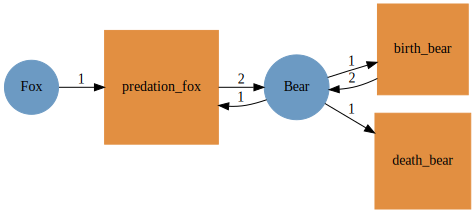

In [141]:
# A Lotka Volterra Model dealing with Foxes and Rabbits
LV = Open(LabelledPetriNet(
    [:Fox, :Rabbit], 
    :birth_rabbit => ((:Rabbit) => (:Rabbit, :Rabbit)),
    :death_fox => ((:Fox) => ()),
    :predation_rabbit => ((:Rabbit, :Fox) => (:Fox, :Fox))
    ))

# Navin's Pigeon Model
N = Open(LabelledPetriNet([:Fox, :Pigeon], 
    :birth_pigeon => ((:Pigeon) => (:Pigeon, :Pigeon)),
    :death_pigeon => ((:Pigeon) => ()),
    :pigeon_eaten => ((:Pigeon, :Fox) => (:Fox))
)
)

# Aditi's Bear Model
A = Open(LabelledPetriNet([:Fox, :Bear], 
    :birth_bear => ((:Bear) => (:Bear, :Bear)),
    :death_bear => ((:Bear) => ()),
    :predation_fox => ((:Bear, :Fox) => (:Bear, :Bear))
)
)

to_graphviz(A)

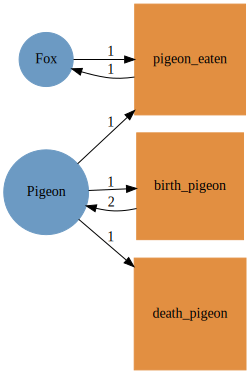

In [125]:
to_graphviz(N)

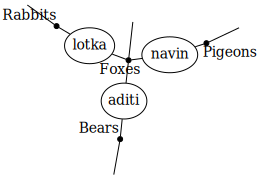

In [142]:
forest_composition_pattern = @relation (Foxes, Pigeons, Rabbits, Bears) where (Foxes, Pigeons, Rabbits, Bears) begin
    lotka(Foxes, Rabbits)
    navin(Foxes, Pigeons)
    aditi(Foxes, Bears)
end 

to_graphviz(forest_composition_pattern, box_labels = :name, junction_labels = :variable)

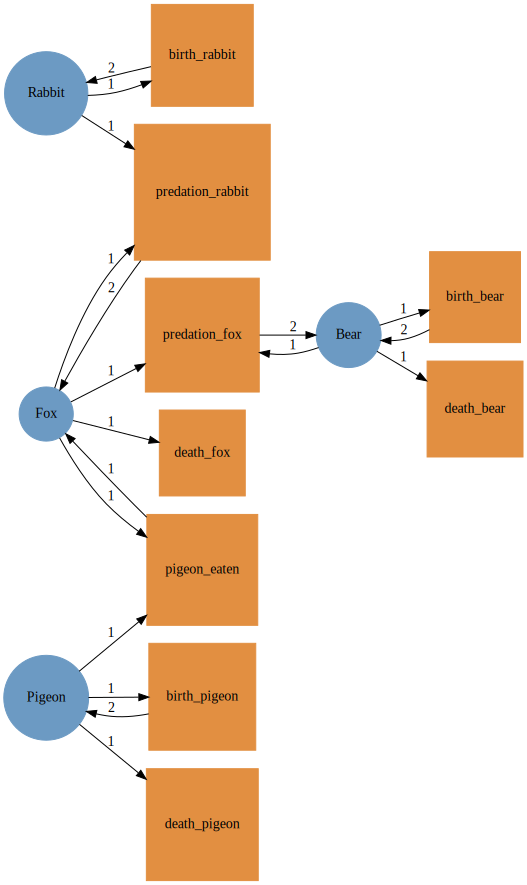

In [144]:
forest_composite = oapply(forest_composition_pattern, 
    Dict(   :lotka => LV,   :navin => N, :aditi => A )
)

to_graphviz(forest_composite)

In [128]:

prey_reproduction_dynamics = ContinuousResourceSharer{Float64}(1, 1, (u, p, t) -> p.alpha * u, [1])
predator_death_dynamics = ContinuousResourceSharer{Float64}(1, 1, (u, p, t) -> -p.gamma * u, [1])
fair_predation_dynamics = ContinuousResourceSharer{Float64}(2, 2, (u, p, t) -> [p.delta * u[1] * u[2], -p.beta * u[1] * u[2]], [1, 2])
unfair_predation_dynamics = ContinuousResourceSharer{Float64}(2, 2, (u, p, t) -> [0, -p.beta * u[1] * u[2]], [1, 2])


ContinuousResourceSharer(ℝ^2 → ℝ^2) with 2 exposed ports

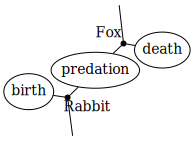

In [129]:
lotka_composition_pattern = @relation (Fox, Rabbit) where (Fox, Rabbit) begin   
    birth(Rabbit)   
    predation(Fox, Rabbit)   
    death(Fox) 
end  

to_graphviz(lotka_composition_pattern,  box_labels = :name, junction_labels = :variable)

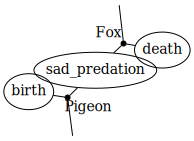

In [130]:
navin_composition_pattern = @relation (Fox, Pigeon) where (Fox, Pigeon) begin   
    birth(Pigeon)   
    sad_predation(Fox, Pigeon)   
    death(Fox) 
end  

to_graphviz(navin_composition_pattern,  box_labels = :name, junction_labels = :variable)

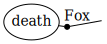

In [131]:
fox_death_pattern = @relation (Fox,) begin
    death(Fox) 
end  

to_graphviz(fox_death_pattern,  box_labels = :name, junction_labels = :variable)

In [132]:
#TODO get UWD from petrinet forest joined at fox

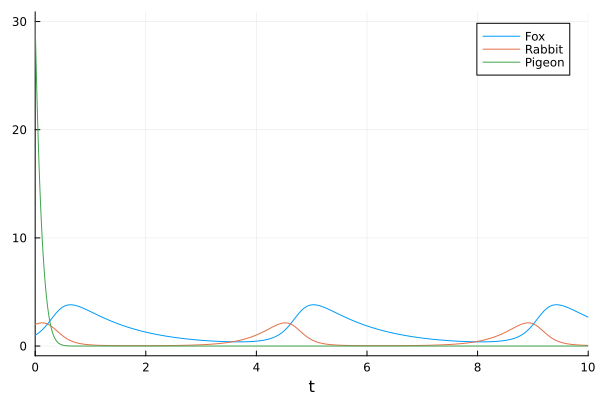

In [140]:
p = LVector(birth_rabbit=3, birth_pigeon=2, death_fox=1, predation_rabbit=2, pigeon_eaten=3, death_pigeon=7, birth_bear = 10, death_bear = 10, predation_fox = 0.4)
u0 = LVector(Fox=1, Rabbit=2, Pigeon=30)
soln = solve(ODEProblem(vectorfield(apex(forest_composite)), u0, (0.0, 10.0), p))
plot(soln)

In [139]:
apex(forest_composite)

T,tname
1,birth_rabbit
2,death_fox
3,predation_rabbit
4,birth_pigeon
5,death_pigeon
6,pigeon_eaten
S,sname
1,Fox
2,Rabbit
3,Pigeon


In [135]:
LV

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{AnonACSet{TypeLevelBasicSchema{Symbol, Tuple{:S}, Tuple{}, Tuple{:Name}, Tuple{(:sname, :S, :Name)}, Tuple{}}, Tuple{Symbol}, @NamedTuple{S::IntParts, Name::IntParts}, @NamedTuple{sname::ACSets.ColumnImplementations.DenseColumn{Union{AttrVar, Symbol}, Vector{Union{AttrVar, Symbol}}}}, IntParts}, LabelledPetriNet}, Multicospan{LabelledPetriNet, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:T, :S, :I, :O}, Tuple{(:it, :I, :T), (:is, :I, :S), (:ot, :O, :T), (:os, :O, :S)}, Tuple{:Name}, Tuple{(:tname, :T, :Name), (:sname, :S, :Name)}, Tuple{}}, @NamedTuple{T::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, S::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, I::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Categ